# 《机器学习》从零开始学(29) 概率图模型专题之贝叶斯网表示

参考教材：

    1）机器学习-周志华-清华大学出版社-2016  链接:https://pan.baidu.com/s/1c1DSE2W 密码:gufi
    2）概率图模型：原理与技术-[美]D·科勒＆[以色列]N·弗里德曼-王飞跃＆韩素青(译)-清华大学出版社-2015  链接:https://pan.baidu.com/s/1dEBk2rf 密码:77hq

所谓“从零开始”面向的对象其实仅指我本人。也就是我的学习笔记。

**注意**：

1. 此笔记是在我理解基础上的梳理和表述。 本节的表述虽然以离散分布为例，但本质上对连续分布也成立。 我们认为离散分布和概率密度是本质是一回事： 离散分布的求和对应着概率密度的积分。 

2. 本笔记的代码无法在聚宽上运行，请复制到本地运行(Python2.7，并安装[pgmpy](https://github.com/pgmpy)及其依赖库)。

3. 由于概率图模型有不少难点，所以本笔记不追求自己实现算法，而利用一个冷门库**[pgmpy](http://pgmpy.org/)**作为演练工具（我暂时没有找到更适合的），而具体算法部分可能会从其源代码中截取一段代码做示例。

4. 我隐隐感觉，在**tensorflow**框架下也应该可以实现概率图模型，这方面留到以后研究吧。

本节重点在 概率图入门之贝叶斯网表示。 

## 1）贝叶斯网初识

**贝叶斯网**与**朴素贝叶斯模型**建立在相同的直观假设上：通过利用分布的条件独立性来获得紧凑而自然的表示。但**贝叶斯网**没有那么强的独立性假设，**贝叶斯网**允许我们根据需要灵活地设置条件独立性，其核心是一个**有向无环图**（DAG），其节点为论域中的随机变量，节点间的有向箭头表示这两个节点的依赖关系。

先上图形成一个感性认识（暂时忽略Python代码，直接看运行结果，图中表格就是对应节点的条件概率表）：

验证模型数据的正确性: True


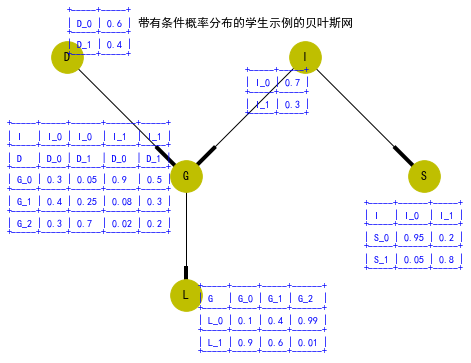

In [6]:
import networkx as nx

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

import matplotlib.pyplot as plt
%matplotlib inline


# 建立一个简单贝叶斯模型骨架
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# 最顶层的两个父节点的概率分布表
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6, 0.4]])  # D: 课程难度(0,1)
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7, 0.3]])  # I: 学生智商(0,1)

# 其它各节点的条件概率分布表（行对应当前节点索引，列对应父节点索引）
cpd_g = TabularCPD(variable='G', variable_card=3,       # G: 考试成绩(0,1,2)
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])
cpd_s = TabularCPD(variable='S', variable_card=2,       # S: SAT成绩(0,1)
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])
cpd_l = TabularCPD(variable='L', variable_card=2,       # L: 推荐质量(0,1)
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

# 将各节点的概率分布表加入网络
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# 验证模型数据的正确性
print u"验证模型数据的正确性:",model.check_model()

# 绘制贝叶斯图(节点+依赖关系)
nx.draw(model, with_labels=True, node_size=1000, font_weight='bold', node_color='y', \
        pos={"L":[4,3],"G":[4,5],"S":[8,5],"D":[2,7],"I":[6,7]})
plt.text(2,7,model.get_cpds("D"), fontsize=10, color='b')
plt.text(5,6,model.get_cpds("I"), fontsize=10, color='b')
plt.text(1,4,model.get_cpds("G"), fontsize=10, color='b')
plt.text(4.2,2,model.get_cpds("L"), fontsize=10, color='b')
plt.text(7,3.4,model.get_cpds("S"), fontsize=10, color='b')
plt.title(u"带有条件概率分布的学生示例的贝叶斯网")
plt.show()

## 2） 属性间联合概率分布的简化

贝叶斯网的特殊结构，能够简化属性间联合概率分布。 

但一般而言，不管属性间是否存在依赖，我们都可以将**属性间的联合概率分布**写成（利用了**概率链式法则**）：

$$
P(x_1,\dots,x_n) = \prod_{j=1}^n P(x_j\ |\ \boldsymbol{\pi}_j), \quad \boldsymbol{\pi}_j = \{x_1,\dots,x_{j-1}\}, \quad P(x_1\ |\ \boldsymbol{\pi}_1) = P(x_1\ |\ \emptyset) = P(x_1)  
$$

不妨为**属性间条件独立性**引入一个简化表示$x \ \bot \ y \ |\ \boldsymbol{z}$（$\boldsymbol{z}$代表一个属性集）：

$$
x \ \bot \ y \ |\ \boldsymbol{z}  \Longleftrightarrow P(x,y\ |\ \boldsymbol{z}) = P(x\ |\ \boldsymbol{z}) P(y\ |\ \boldsymbol{z})
$$

作为**联合概率分布的简化**的示例，考虑一个最简单的**马尔科夫假设**：$x_{j+1} \ \bot \ \boldsymbol{\pi}_j\ |\ x_j, \quad j=2,\dots,n$。 如果递归地应用这个假设，必然可以推导出$\boldsymbol{\pi}_j$始终是一个单元素集合，即$\boldsymbol{\pi}_j=\{x_{j-1}\}$，进而获得**联合概率分布**的简化形式：

$$
P(x_1,\dots,x_n) = \prod_{j=1}^n P(x_j\ |\ x_{j-1}), \quad P(x_1\ |\ x_{0}) = P(x_1\ |\ \boldsymbol{\pi}_1) = P(x_1) 
$$

这就是随机过程中的**马尔科夫链**，这是一个1维序列，而$P(x_j\ = u|\ x_{j-1} = v)$构成的矩阵被称为节点$x_{j-1}$的**状态转移矩阵**。

## 3）有向无环图

直观上看，前面的**马尔科夫链**必然是一个最简单**有向无环图**：这明显是一个有向链，并且还不构成环。

**有向**对应着**条件概率**,而**无环**则说明属性自身的条件概率毫无意义。

更一般而言，**贝叶斯网**，就是各属性间的依赖关系图（**有向无环图**表示之）+ 各属性相对其依赖属性的**条件概率表**。 当然这个**有向无环图**就不像**马尔科夫链**那么简单。

## 4）三种元结构

有向无环图可能有一定的复杂度，但还是可以由如下3种**元结构**构成：

![典型依赖关系](https://jiage.la/upload/201709213571693991840.png)

对应的**条件概率表**示例：

![条件概率表](https://jiage.la/upload/201709213574371101930.png)

- **同父结构** （联合概率分布的简化，及条件独立性）

$$
\begin{array}
& \quad &.& P(x_1,x_3,x_4) = P(x_1) P(x_3\ |\ x_1) P(x_4\ |\ x_1) & 与图等价的联合分布 \\
&\Rightarrow& P(x_3,x_4 \ | \ x_1) = P(x_3\ |\ x_1) P(x_4\ |\ x_1) & 两边除 P(x_1)
\end{array}
$$

- **V型结构** （联合概率分布的简化，及**无**条件独立性，但条件独立性不成立）

$$
\begin{array}
& \quad &.& P(x_1,x_2,x_4) = P(x_1) P(x_2) P(x_4\ |\ x_1,x_2) & 与图等价的联合分布 \\
&\Rightarrow& P(x_1,x_2) = P(x_1) P(x_2) & 对 x_4 求和求积分
\end{array}
$$

- **顺序结构** （联合概率分布的简化，及条件独立性）

$$
\begin{array}
& \quad &.& P(x,y,z) = P(x\ |\ z) P(y\ |\ x) P(z) & 与图等价的联合分布 \\
&\Rightarrow& P(y,z \ | \ x) = P(y\ |\ x) P(z\ |\ x) & 利用贝叶斯定理将 P(x\ |\ z) 颠倒，然后两边除 P(x)
\end{array}
$$


## 5) 贝叶斯网络的一般性结构

**贝叶斯网络**$B$，由**有向无环图**$G$和**条件概率表集**$\Theta$两部分组成，即$B = (G,\Theta)$。 而属性$x_j$在$G$中的**父节点集**顺势也记为$\boldsymbol{\pi}_j$，那么$\Theta$包含了每个属性的**条件概率表**$\theta_{x_j\ |\ \boldsymbol{\pi}_i}= P_B(x_j\ |\ \boldsymbol{\pi}_j)$。

参考元结构的联合概率分布，基于**贝叶斯网络**$B = (G,\Theta)$的所有属性的联合概率分布可写成**因子分解**形式：

$$
P_B(\boldsymbol{x}\ |\ \boldsymbol{\theta}) = \prod_{j=1}^n P_B(x_j\ |\ \boldsymbol{\pi}_j) = \prod_{j=1}^n \theta_{x_j\ |\ \boldsymbol{\pi}_j} 
$$

【注意】，形式上和前面一般的联合概率分布一样，但贝叶斯网络中任意节点$x_j$的父节点集$\boldsymbol{\pi}_j$的范围是不一样的。

特别地，对前面学生示例的贝叶斯网，联合概率分布可写成：

$$
P(I,D,G,S,L) = P(I) P(D) P(G\ |\ I, D) P(S\ |\ I) P(L\ |\ G)
$$

## 6)“道德图”：快速确定属性间的条件独立性


根据前面三种元结构的条件独立性特点：只有**V型结构**的非中间点没有条件独立性（虽然具备无条件独立性），而另外两种与依赖是否有向是无关的。 

基于这种观察，可以将所有**V型结构**的父节点用无向连接，然后将所有有向改成无向，这样的图叫做"**道德图**"。

在**道德图**中，如果变量$x$和$y$能在图上被变量集合$\boldsymbol{z}$分开，则称$x$和$y$被$\boldsymbol{z}$**有向分离**，同时具有条件独立性：$x \ \bot \ y \ |\ \boldsymbol{z}$。

先看下面学生示例的贝叶斯网的所有独立性（暂时不要管其实现原理，不妨假设是正确的），然后人工判断是否一致（符合元结构的，按**元结构的独立性**；否则按**有向分离**）。如果一致，说明我们的理解是正确的，否则应该继续看书琢磨：

In [2]:
model.get_independencies()

(I _|_ D)
(I _|_ D | S)
(I _|_ L | G)
(I _|_ L | S, G)
(I _|_ L | D, G)
(I _|_ L | S, D, G)
(S _|_ D)
(S _|_ D, G, L | I)
(S _|_ L | G)
(S _|_ L, G | I, D)
(S _|_ D, L | I, G)
(S _|_ D, G | I, L)
(S _|_ L | D, G)
(S _|_ L | I, D, G)
(S _|_ G | I, D, L)
(S _|_ D | I, L, G)
(D _|_ I, S)
(D _|_ S | I)
(D _|_ I | S)
(D _|_ L | G)
(D _|_ S | I, L)
(D _|_ S, L | I, G)
(D _|_ L | S, G)
(D _|_ L | I, S, G)
(D _|_ S | I, L, G)
(G _|_ S | I)
(G _|_ S | I, D)
(G _|_ S | I, L)
(G _|_ S | I, D, L)
(L _|_ S | I)
(L _|_ I, S, D | G)
(L _|_ S | I, D)
(L _|_ S, D | I, G)
(L _|_ I, D | S, G)
(L _|_ I, S | D, G)
(L _|_ D | I, S, G)
(L _|_ S | I, D, G)
(L _|_ I | S, D, G)

## 7) 贝叶斯网推断

假如我们已经知道所有属性的**联合概率分布**$P_B(\boldsymbol{x}\ |\ \boldsymbol{\theta})$，我们可以根据已经观察到的**显式属性集**$\boldsymbol{x}_v$推断出无法观察到的**隐式属性集**$\boldsymbol{x}_h$：

$$
P(\boldsymbol{x}_h\ |\ \boldsymbol{x}_v:\boldsymbol{\theta}) = \dfrac{P(\boldsymbol{x}_h, \boldsymbol{x}_v\ |\ \boldsymbol{\theta}) }{P(\boldsymbol{x}_v\ |\ \boldsymbol{\theta})} = \dfrac{P(\boldsymbol{x}_h, \boldsymbol{x}_v\ |\ \boldsymbol{\theta}) }{\sum_{\boldsymbol{x}'_v}P(\boldsymbol{x}'_v\ |\ \boldsymbol{\theta})} \propto P(\boldsymbol{x}_h, \boldsymbol{x}_v\ |\ \boldsymbol{\theta})
$$

在实际推断中，$P(\boldsymbol{x}_v\ |\ \boldsymbol{\theta})$一般是归一化常数。

如果**隐式属性集**$\boldsymbol{x}_h$中，有一部分属性我们不感兴趣的, 那么不妨将$\boldsymbol{x}_h$分给成**查询属性集**$\boldsymbol{x}_q$和**干扰属性集**$\boldsymbol{x}_n$，那么我们可以对$\boldsymbol{x}_n$做边缘求和(积分)：

$$
P(\boldsymbol{x}_q\ |\ \boldsymbol{x}_v:\boldsymbol{\theta}) = \sum_{\boldsymbol{x}_n} P(\boldsymbol{x}_q,\boldsymbol{x}_n\ |\ \boldsymbol{x}_v:\boldsymbol{\theta})
$$


遗憾的是，贝叶斯网推断是一个NP难题，需要采用近似推断。 【在后面的学习中会继续展开】

## 8) 推理模式

下面根据学生示例的贝叶斯网为例子。

- **因果推理**

根据这个玩具贝叶斯网可以算出**好推荐**的**先验概率**:  $P(l^1)=50.2\%$。

如果我们有知道这个人不太聪明，那么获得**好推荐**的概率就降低到：$P(l^1\ |\ i^0)=38.9\%$

如果我们进一步知道对应的课程比较简单，，那么获得**好推荐**的概率又上升到：$P(l^1\ |\ i^0, d^0)=51.3\%$

像这种“顺流而下”的从原因推结果的查询(注意看前面的图)，被称作**因果推理**或**预测**。

【注意】不妨先手工算出，然后对比之。目前重点是理解概念。 下面的计算仅仅用来确认手工计算的正确性。 (后同)

In [3]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

q = infer.query(variables=['L'], evidence={})
print q['L']

q = infer.query(variables=['L'], evidence={'I':0})
print q['L']

q = infer.query(variables=['L'], evidence={'I':0, 'D':0})
print q['L']

+-----+----------+
| L   |   phi(L) |
|-----+----------|
| L_0 |   0.4977 |
| L_1 |   0.5023 |
+-----+----------+
+-----+----------+
| L   |   phi(L) |
|-----+----------|
| L_0 |   0.6114 |
| L_1 |   0.3886 |
+-----+----------+
+-----+----------+
| L   |   phi(L) |
|-----+----------|
| L_0 |   0.4870 |
| L_1 |   0.5130 |
+-----+----------+


- **证据推理**

根据玩具贝叶斯网可以算出学生**聪明**的**先验概率**:  $P(i^1)=30\%$。

如果我们有知道他课程成绩优秀，那么该学生**聪明**的概率就降低到：$P(i^1\ |\ g^2)=7.9\%$

如果丢弃了课程成绩，但知道他获得一个不好推荐，那么获得**聪明**的概率只降到：$P(i^1\ |\ l^0)=14\%$

像这种从结果推原因的查询(注意看前面的图)，被称作**证据推理**或**解释**。

In [4]:
q = infer.query(variables=['I'], evidence={})
print q['I']

q = infer.query(variables=['I'], evidence={'G':2})
print q['I']

q = infer.query(variables=['I'], evidence={'L':0})
print q['I']

+-----+----------+
| I   |   phi(I) |
|-----+----------|
| I_0 |   0.7000 |
| I_1 |   0.3000 |
+-----+----------+
+-----+----------+
| I   |   phi(I) |
|-----+----------|
| I_0 |   0.9211 |
| I_1 |   0.0789 |
+-----+----------+
+-----+----------+
| I   |   phi(I) |
|-----+----------|
| I_0 |   0.8600 |
| I_1 |   0.1400 |
+-----+----------+


- **因果间推理**

前一小段我们已经知道： 如果学生课程成绩优秀，那么该他**聪明**的概率是：$P(i^1\ |\ g^2)=7.9\%$。

另一方面，如果发现该课程是一门很困难的课程，那么他**聪明**的概率上升到：$P(i^1\ |\ g^2, d^1)=11\%$。

事实上，我通过课程难度**解释消除**了成绩降低这一事件影响。 而**解释消除**是**因果间推理**的一个示例。 这类相同结果的不同原因间的相互影响的推理，被称作**因果间推理**。

In [5]:
q = infer.query(variables=['I'], evidence={'G':2,'D':1})
print q['I']

+-----+----------+
| I   |   phi(I) |
|-----+----------|
| I_0 |   0.8909 |
| I_1 |   0.1091 |
+-----+----------+


## 9) 贝叶斯网学习

**贝叶斯网的推断**的前提是已经知道所有属性的联合概率分布，而联合概率分布式依据**贝叶斯网**的结构(向无环图)及参数(条件概率表)。 所以原则上存在两类学习： **结构学习**和**参数学习**。

遗憾的是：**结构学习**也是一个NP难题，需要采用近似方式，比如贪心法，有向无环图限定为树。 【在后面的学习中会继续展开】

一旦确定了结构，**参数学习**稍微容易一些。方法就是"从零开始学(27) "中的**极大拟然估计**：

如果给定一个训练集$\{x_i\}_1^m$ ，参数估计就变成一个优化问题，根据最大拟然估计原理，可以获得模型参数：$\boldsymbol{\theta}$的最大拟然估计$\hat{\boldsymbol{\theta}}$ ：
$$
\hat{\boldsymbol{\theta}}=\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \  \sum_{i=1}^m \ln P(\boldsymbol{x}_{i,v}\ |\ \boldsymbol{\theta})
$$
